In [31]:
# Jalankan dulu cell ini
%matplotlib inline

import os, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Path ke CSV kamu (ganti kalau perlu)
CSV_PATH = "/home/wgg/Downloads/student_exam_scores.csv"
assert os.path.exists(CSV_PATH), f"CSV tidak ditemukan: {CSV_PATH}"


In [32]:
# Load dataset
df = pd.read_csv(CSV_PATH)
df.head(10)


,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3
5,S006,8.4,5.1,58.5,75,35.7
6,S007,10.8,6.0,54.2,88,37.9
7,S008,2.0,4.3,75.8,55,18.3
8,S009,5.6,5.9,81.6,84,34.7
9,S010,1.3,8.9,66.8,70,24.7


In [34]:
# Tentukan target (y) otomatis; kalau tidak ada yang cocok, pakai kolom terakhir
cols = list(df.columns)
target_candidates = [c for c in cols if c.lower() in ["score","final_score","exam_score","final","target","y"]]
y_col = target_candidates[0] if target_candidates else cols[-1]
X_cols = [c for c in cols if c != y_col]

# Ambil fitur numerik & target numerik
X = df[X_cols].select_dtypes(include=[np.number]).copy()
y = pd.to_numeric(df[y_col], errors="coerce")

# Drop baris yang ada NaN
valid = ~(X.isna().any(axis=1) | y.isna())
X = X.loc[valid].reset_index(drop=True)
y = y.loc[valid].reset_index(drop=True)

print("Features:", list(X.columns))
print("Target  :", y_col)


Features: ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores']
Target  : exam_score


In [35]:
# Descriptive stats
desc_X = X.describe().T[['mean','50%','std']].rename(columns={'50%':'median'})
desc_y = pd.DataFrame({'mean':[y.mean()],'median':[y.median()],'std':[y.std(ddof=1)]}, index=[y_col])
display(desc_X)
display(desc_y)


,mean,median,std
hours_studied,6.3255,6.15,3.227317
sleep_hours,6.6220,6.70,1.497138
attendance_percent,74.8300,75.25,14.249905
previous_scores,66.8000,67.50,15.663869


,mean,median,std
exam_score,33.955,34.05,6.789548


In [36]:
# Train/Test split (80/20, seed tetap)
rng = np.random.default_rng(42)
idx = np.arange(len(X)); rng.shuffle(idx)
split = int(0.8*len(X))
train_idx, test_idx = idx[:split], idx[split:]

X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

# Standardisasi (fit di train, apply ke test)
X_mean = X_train.mean()
X_std  = X_train.std(ddof=0).replace(0, 1.0)

X_train_std = (X_train - X_mean) / X_std
X_test_std  = (X_test  - X_mean) / X_std

def add_bias(A: np.ndarray) -> np.ndarray:
    return np.c_[np.ones((A.shape[0], 1)), A]

Xtr = add_bias(X_train_std.values)
Xte = add_bias(X_test_std.values)
ytr = y_train.values.reshape(-1, 1)
yte = y_test.values.reshape(-1, 1)


In [37]:
def normal_equation(X, y):
    Xb = add_bias_column(X)            # m x (n+1)
    Xt = mat_transpose(Xb)             # (n+1) x m
    XtX = mat_mul(Xt, Xb)              # (n+1) x (n+1)
    Xty = mat_vec_mul(Xt, y)           # (n+1)
    XtX_inv = mat_inverse_gauss_jordan(XtX)
    theta = mat_vec_mul(XtX_inv, Xty)  # (n+1)
    return theta  # list panjang n+1


In [38]:
def bgd(X, y, alpha=0.1, epochs=300):
    Xb = add_bias_column(X)      # m x (n+1)
    m, n1 = len(Xb), len(Xb[0])
    theta = [0.0]*n1
    history = []

    for _ in range(epochs):
        # grad = (2/m) * X^T (X theta - y)
        preds = mat_vec_mul(Xb, theta)
        err = [pi - yi for pi, yi in zip(preds, y)]
        # X^T * err
        Xt = mat_transpose(Xb)
        grad = mat_vec_mul(Xt, err)
        grad = [ (2.0/m)*g for g in grad ]
        # update
        theta = [ti - alpha*gi for ti, gi in zip(theta, grad)]
        history.append(mse(Xb, y, theta))
    return theta, history


In [39]:
def sgd(X, y, epochs=50, t0=5.0, t1=50.0, shuffle=True):
    import random
    Xb = add_bias_column(X)
    m, n1 = len(Xb), len(Xb[0])
    theta = [0.0]*n1
    hist = []
    t = 0  # counter untuk schedule

    def lr(step):
        return 1.0 / (t0 + t1*step)

    indices = list(range(m))
    for _ in range(epochs):
        if shuffle:
            random.shuffle(indices)
        for i in indices:
            xi = Xb[i]        # (n+1)
            yi = y[i]
            # grad_i = 2 * x_i^T (x_i theta - y_i)
            pred_i = sum(xij*thj for xij, thj in zip(xi, theta))
            err_i = pred_i - yi
            grad_i = [ 2.0 * xij * err_i for xij in xi ]
            t += 1
            eta = lr(t)
            theta = [ti - eta*gi for ti, gi in zip(theta, grad_i)]
        hist.append(mse(Xb, y, theta))
    return theta, hist


In [40]:
def mse_cost(Xm, ym, theta):
    m = len(ym)
    err = Xm @ theta - ym
    return float((err.T @ err) / m)

def grad(Xm, ym, theta):
    m = len(ym)
    return (2/m) * (Xm.T @ (Xm @ theta - ym))


In [41]:
t0 = time.perf_counter()
theta_ne = np.linalg.pinv(Xtr.T @ Xtr) @ Xtr.T @ ytr
t_ne = time.perf_counter() - t0
mse_ne = mse_cost(Xte, yte, theta_ne)

print("NE - waktu(s):", t_ne, " MSE(test):", mse_ne)


NE - waktu(s): 0.0818482849999782  MSE(test): 8.410803931422993


/tmp/ipykernel_5511/3103864548.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((err.T @ err) / m)


In [42]:
def batch_gradient_descent(Xm, ym, alpha=0.1, n_epochs=300):
    theta = np.zeros((Xm.shape[1], 1))
    history = []
    for _ in range(n_epochs):
        theta = theta - alpha * grad(Xm, ym, theta)
        history.append(mse_cost(Xm, ym, theta))
    return theta, history

alphas = [0.001, 0.01, 0.05, 0.1, 0.2]
best_alpha, best_hist, best_theta_bgd = None, None, None
best_final_cost = math.inf

t0 = time.perf_counter()
for a in alphas:
    th, hist = batch_gradient_descent(Xtr, ytr, alpha=a, n_epochs=300)
    if hist[-1] < best_final_cost:
        best_final_cost = hist[-1]
        best_alpha, best_hist, best_theta_bgd = a, hist, th
t_bgd = time.perf_counter() - t0
mse_bgd = mse_cost(Xte, yte, best_theta_bgd)

print("BGD - alpha:", best_alpha, " waktu(s):", t_bgd, " MSE(test):", mse_bgd)


BGD - alpha: 0.2  waktu(s): 0.07664028599992889  MSE(test): 8.410803931422997


/tmp/ipykernel_5511/3103864548.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((err.T @ err) / m)


In [43]:
def sgd(Xm, ym, n_epochs=50, t0_val=5.0, t1_val=50.0, shuffle=True):
    m, n = Xm.shape
    theta = np.zeros((n, 1))
    history, iteration = [], 0
    rng_local = np.random.default_rng(123)

    def lr(t): return 1.0 / (t0_val + t1_val*t)

    for _ in range(n_epochs):
        indices = np.arange(m)
        if shuffle:
            rng_local.shuffle(indices)
        for i in indices:
            xi = Xm[i:i+1].T
            yi = ym[i:i+1]
            grad_i = 2 * (xi @ ((xi.T @ theta) - yi))
            eta = lr(iteration + 1)
            theta = theta - eta * grad_i
            iteration += 1
        history.append(mse_cost(Xm, ym, theta))
    return theta, history

t0 = time.perf_counter()
theta_sgd, hist_sgd = sgd(Xtr, ytr, n_epochs=50, t0_val=5.0, t1_val=50.0, shuffle=True)
t_sgd = time.perf_counter() - t0
mse_sgd = mse_cost(Xte, yte, theta_sgd)

print("SGD - waktu(s):", t_sgd, " MSE(test):", mse_sgd)


SGD - waktu(s): 0.1860936389998642  MSE(test): 575.5092601112774


/tmp/ipykernel_5511/3103864548.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((err.T @ err) / m)


In [44]:
def mbgd(Xm, ym, batch_size=16, alpha=0.05, n_epochs=150, shuffle=True):
    m, n = Xm.shape
    theta = np.zeros((n, 1))
    history = []
    rng_local = np.random.default_rng(999)
    for _ in range(n_epochs):
        indices = np.arange(m)
        if shuffle:
            rng_local.shuffle(indices)
        for start in range(0, m, batch_size):
            end = min(start + batch_size, m)
            batch_idx = indices[start:end]
            Xb = Xm[batch_idx]; yb = ym[batch_idx]
            theta = theta - alpha * grad(Xb, yb, theta)
        history.append(mse_cost(Xm, ym, theta))
    return theta, history

batch_sizes = [8, 16, 32]
alphas_mbgd = [0.01, 0.05, 0.1]
best_cfg, best_hist_m, best_theta_m = None, None, None
best_final_cost_m = math.inf

t0 = time.perf_counter()
for bs in batch_sizes:
    for a in alphas_mbgd:
        th, hist = mbgd(Xtr, ytr, batch_size=bs, alpha=a, n_epochs=150)
        if hist[-1] < best_final_cost_m:
            best_final_cost_m = hist[-1]
            best_cfg, best_hist_m, best_theta_m = (bs, a), hist, th
t_mbgd = time.perf_counter() - t0
mse_mbgd = mse_cost(Xte, yte, best_theta_m)

print("MBGD - cfg:", best_cfg, " waktu(s):", t_mbgd, " MSE(test):", mse_mbgd)


/tmp/ipykernel_5511/3103864548.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((err.T @ err) / m)


MBGD - cfg: (32, 0.01)  waktu(s): 0.34693506200028423  MSE(test): 8.405921937312833


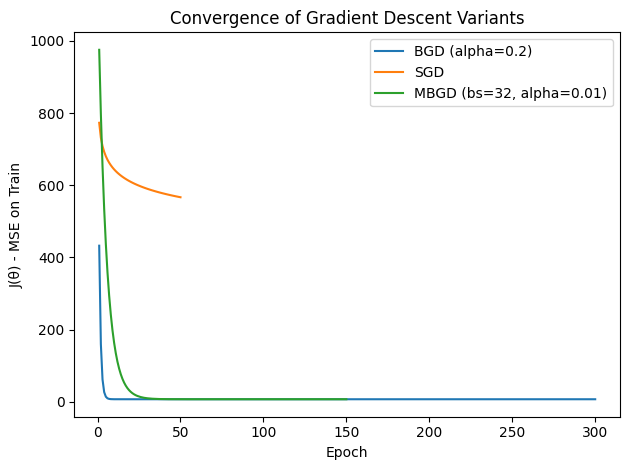

In [45]:
plt.figure()
plt.plot(range(1, len(best_hist)+1), best_hist, label=f"BGD (alpha={best_alpha})")
plt.plot(range(1, len(hist_sgd)+1), hist_sgd, label="SGD")
plt.plot(range(1, len(best_hist_m)+1), best_hist_m, label=f"MBGD (bs={best_cfg[0]}, alpha={best_cfg[1]})")
plt.xlabel("Epoch")
plt.ylabel("J(θ) - MSE on Train")
plt.title("Convergence of Gradient Descent Variants")
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
results = pd.DataFrame([
    {"Metode":"Normal Equation", "Waktu Komputasi (detik)": t_ne,   "MSE (Test)": mse_ne},
    {"Metode":"Batch GD",        "Waktu Komputasi (detik)": t_bgd,  "MSE (Test)": mse_bgd},
    {"Metode":"SGD",             "Waktu Komputasi (detik)": t_sgd,  "MSE (Test)": mse_sgd},
    {"Metode":"Mini-Batch GD",   "Waktu Komputasi (detik)": t_mbgd, "MSE (Test)": mse_mbgd},
]).sort_values("MSE (Test)").reset_index(drop=True)

results


,Metode,Waktu Komputasi (detik),MSE (Test)
0,Mini-Batch GD,0.346935,8.405922
1,Normal Equation,0.081848,8.410804
2,Batch GD,0.076640,8.410804
3,SGD,0.186094,575.509260
